In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# plt.style.use('fivethirtyeight')
# sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df_offer= pd.read_json('portfolio.json', orient='records', lines=True)
df_offer.head()
# profile = pd.read_json('profile.json', orient='records', lines=True)
# transcript = pd.read_json('transcript.json', orient='records', lines=True)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
df_customer = pd.read_json('profile.json', orient='records', lines=True)

In [4]:
df_transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [5]:
df_offer.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
df_transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [7]:
missing_gender = df_customer[df_customer['gender'].isna()]
missing_income = df_customer[df_customer['income'].isna()]

np.sum(missing_gender['id'] == missing_income['id'])

2175

In [8]:
id_to_remove = missing_income['id']
df_customer_no_na = df_customer[~df_customer['id'].isin(id_to_remove)]
df_customer_no_na = df_customer_no_na.reset_index(drop = True)
df_customer_no_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


In [9]:
# Check data types

In [10]:
df_offer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [11]:
channels_0 = df_offer['channels'][0]
offer_type_0 = df_offer['offer_type'][0]
id_0 = df_offer['id'][0]

In [12]:
df_customer_no_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14825 entries, 0 to 14824
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               14825 non-null  int64  
 2   id                14825 non-null  object 
 3   became_member_on  14825 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 579.2+ KB


In [13]:
df_customer_no_na['became_member_on'] = pd.to_datetime(df_customer_no_na['became_member_on'], format = '%Y%m%d')


In [14]:
df_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [15]:
# Rename column time
df_transcript.rename(columns = {'time' : 'hours_since_start'}, inplace = True)
df_transcript.head(1)

,person,event,value,hours_since_start
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [16]:
# Data Transformation

In [17]:
# Sort df offers
df_offer = df_offer.sort_values(['offer_type', 'difficulty']).reset_index(drop = True)

# Add  offer_alias
from string import ascii_uppercase
df_offer['offer_alias'] = [ascii_uppercase[i] for i in range(df_offer.shape[0])]
df_offer

,reward,channels,difficulty,duration,offer_type,id,offer_alias
0,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,A
1,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,B
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,C
3,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,D
4,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,E
5,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,F
6,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,G
7,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,H
8,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,I
9,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,J


In [18]:

value_column = df_transcript['value']

value_column[:3]

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
Name: value, dtype: object

In [19]:
# Extract the keys
dictionary_key_column = [list(d.keys())[0] for d in value_column]
# Extract the values
dictionary_value_column = [list(d.values())[0] for d in value_column]
# Create a df containing the keys and values of the dictionary elements of `value_column`
value_column_split = pd.DataFrame(columns = ['dict_key', 'dict_value'])
value_column_split['dict_key'] = dictionary_key_column
value_column_split['dict_value'] = dictionary_value_column
value_column_split.head(3)

,dict_key,dict_value
0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer id,2906b810c7d4411798c6938adc9daaa5


In [20]:
# Replace `value` column with df `value_column_split`
df_transcript_value_mod = df_transcript.drop('value', axis = 1)
df_transcript_value_mod = pd.concat([df_transcript_value_mod, value_column_split], axis = 1)

In [21]:
df_transcript_value_mod.columns.values

array(['person', 'event', 'hours_since_start', 'dict_key', 'dict_value'],
      dtype=object)

In [22]:
col_names = ['person', 'event', 'dict_key', 'dict_value', 'hours_since_start']
df_transcript_value_mod = df_transcript_value_mod[col_names]
df_transcript_value_mod.sample(3)

,person,event,dict_key,dict_value,hours_since_start
143543,0a0e3bd8c3dc4127ada0c58bcf997da7,offer viewed,offer id,5a8bc65990b245e5a138643cd4eb9837,378
21989,40a030abad2b480d8ef6a31b6238a0e8,transaction,amount,3.78,18
71787,6e3adde58aa54299b5ed23ae474c9ea0,offer viewed,offer id,5a8bc65990b245e5a138643cd4eb9837,174


In [23]:
offers = df_offer.copy()
customers = df_customer_no_na.copy()
transcripts = df_transcript_value_mod.copy()

In [24]:
#  Exploratory Data Analysis

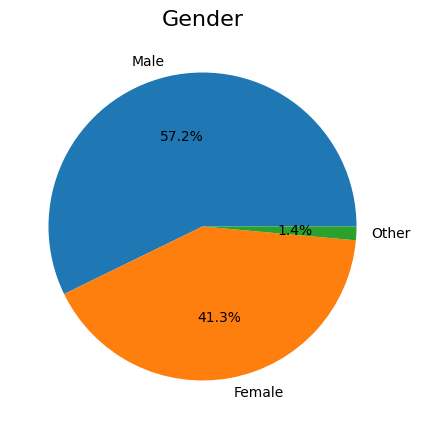

In [25]:
# Univariate Analysis - gender
wedge_size =  df_customer_no_na['gender'].value_counts()
wedge_label = ['Male', 'Female', 'Other']
plt.figure(figsize = (5,5))
plt.pie(x = wedge_size, labels = wedge_label, autopct = '%1.1f%%')
plt.title('Gender', fontsize = 16)
plt.show()

count    14825.000000
mean        54.393524
std         17.383705
min         18.000000
25%         42.000000
50%         55.000000
75%         66.000000
max        101.000000
Name: age, dtype: float64


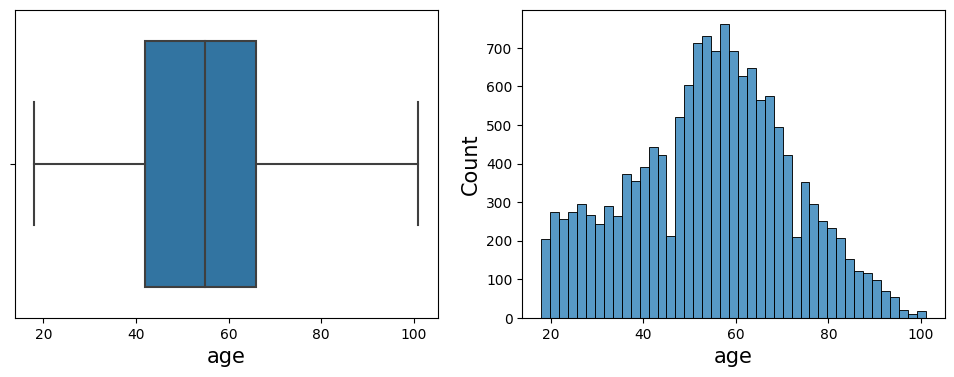

In [26]:
# Univariate Analysis - age
fig, axs = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(data = customers, x = 'age', ax = axs[0])
sns.histplot(data = customers, x = 'age', ax = axs[1])
axs[0].xaxis.label.set_size(15)
axs[1].xaxis.label.set_size(15)
axs[1].yaxis.label.set_size(15)

print(customers['age'].describe())

In [27]:
# Divide customers into age groups

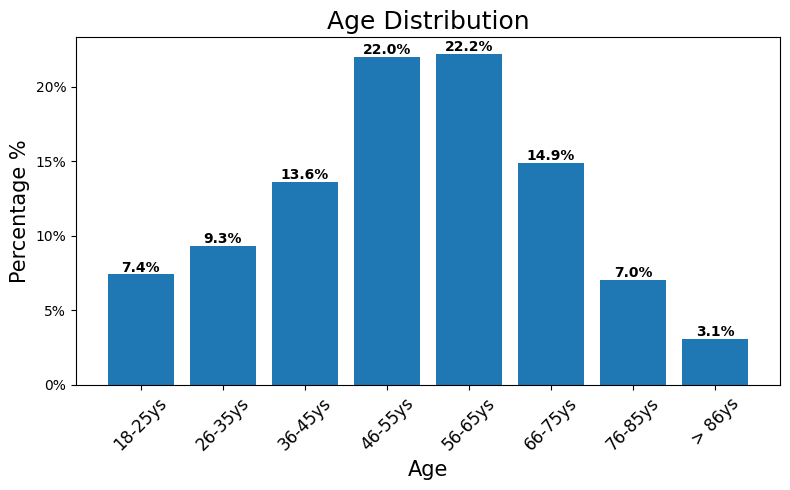

In [28]:
age_group = pd.cut(customers['age'],
      bins = [customers['age'].min(), 26, 36, 46, 56, 66, 76, 86, customers['age'].max()],
      labels = ['18-25ys', '26-35ys', '36-45ys', '46-55ys', '56-65ys', '66-75ys', '76-85ys', '> 86ys'])
customers['age_group'] = age_group

age_group_percentage = (customers.value_counts('age_group').sort_index() / customers.shape[0] * 100).round(1)
plt.figure(figsize = (8, 5))
yticks = np.arange(0,25,5)
yticklabels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = yticklabels)
plt.xticks(rotation = 45, fontsize = 12)
plt.xlabel('Age', fontsize = 15)
plt.ylabel('Percentage %', fontsize = 15)
plt.title('Age Distribution', fontsize = 18)

bar_plot = plt.bar(x = age_group_percentage.index.values, height = age_group_percentage)
for i,bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(age_group_percentage[i]) + '%',
            ha = 'center', weight = 'bold')

plt.tight_layout()
plt.show()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64


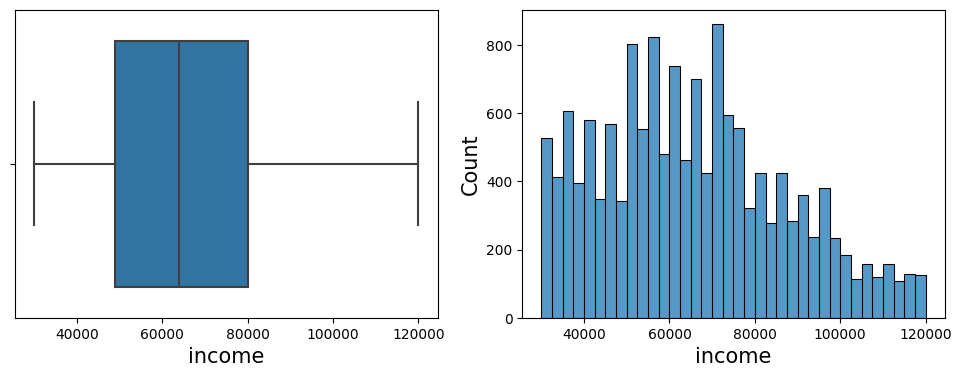

In [29]:
# Univariate Analysis - income
fig, axs = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(data = customers, x = 'income', ax = axs[0])
sns.histplot(data = customers, x = 'income', ax = axs[1])
axs[0].xaxis.label.set_size(15)
axs[1].xaxis.label.set_size(15)
axs[1].yaxis.label.set_size(15)

print(customers['income'].describe())

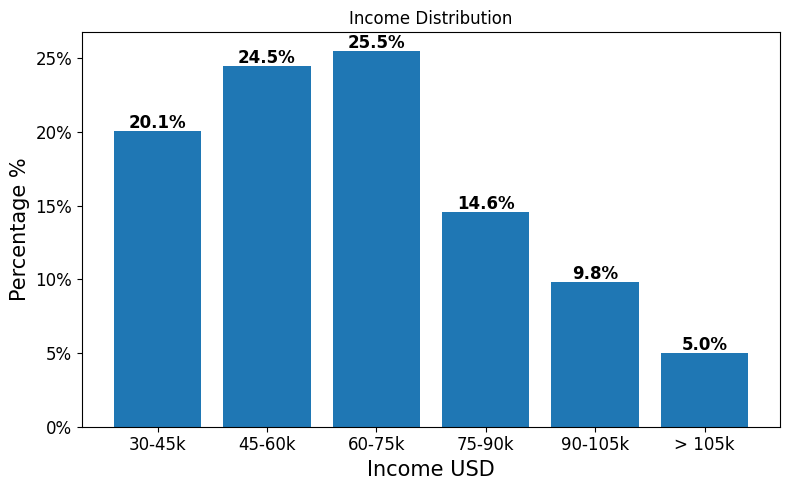

In [30]:
income_group = pd.cut(customers['income'],
      bins = [customers['income'].min(), 45000, 60000, 75000, 90000, 105000, customers['income'].max()],
      labels = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '> 105k'])
customers['income_group'] = income_group

income_group_percentage = (customers.value_counts('income_group').sort_index() / customers.shape[0] * 100).round(1)
plt.figure(figsize = (8, 5))
yticks = np.arange(0,30,5)
yticklabels = [str(y) + '%' for y in yticks]
plt.yticks(yticks, labels = yticklabels, fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Income USD', fontsize = 15)
plt.ylabel('Percentage %', fontsize = 15)
plt.title('Income Distribution')

bar_plot = plt.bar(x = income_group_percentage.index.values, height = income_group_percentage)
for i,bar in enumerate(bar_plot.patches):
    x, y = bar.get_xy()
    plt.text(x+bar.get_width()/2, y+bar.get_height()+0.2,
            str(income_group_percentage[i]) + '%',
            ha = 'center', weight = 'bold', fontsize = 12)

plt.tight_layout()
plt.show()

In [31]:
# Create a new df focusing on the time customers became members
df_member = customers[['id', 'became_member_on']]

# Add columns `year`, `month`, `day_of_week`
df_member = df_member.assign(year = df_member.became_member_on.dt.year,
                             month = df_member.became_member_on.dt.month,
                             day = df_member.became_member_on.dt.day,
                             month_name = df_member.became_member_on.dt.month_name(),
                             day_of_week = df_member.became_member_on.dt.weekday,
                             day_name = df_member.became_member_on.dt.day_name())
df_member.head(3)

,id,became_member_on,year,month,day,month_name,day_of_week,day_name
0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,2017,7,15,July,5,Saturday
1,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,2017,5,9,May,1,Tuesday
2,e2127556f4f64592b11af22de27a7932,2018-04-26,2018,4,26,April,3,Thursday


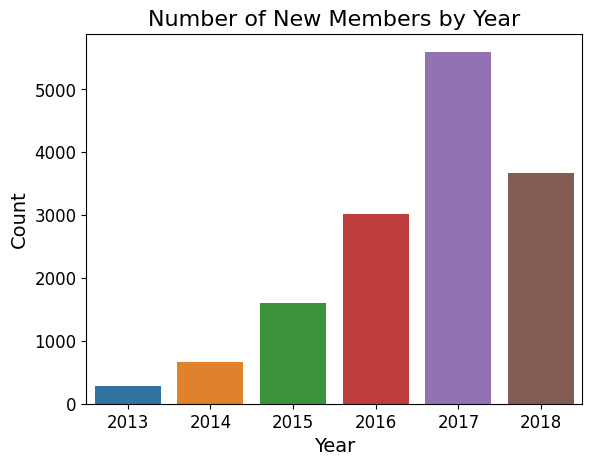

In [32]:
# Member growth by year
sns.countplot(data = df_member, x = 'year')
plt.title('Number of New Members by Year', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Year', fontsize = 14); plt.ylabel('Count', fontsize = 14)
plt.show()

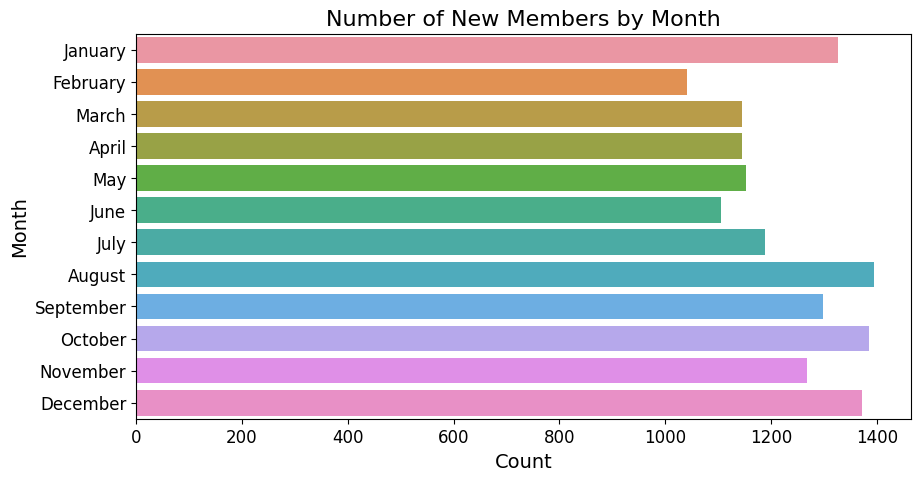

In [33]:
# Member growth by Month
plt.figure(figsize = (10,5))
sns.countplot(data = df_member.sort_values('month'), y = 'month_name')
plt.title('Number of New Members by Month', fontsize = 16)
plt.xticks(fontsize = 12); plt.yticks(fontsize = 12)
plt.xlabel('Count', fontsize = 14); plt.ylabel('Month', fontsize = 14)
plt.show()

              age
gender           
F       57.544950
M       52.116690
O       54.400943


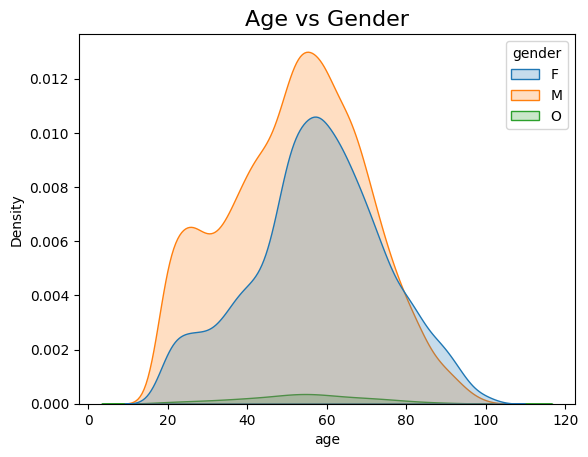

In [34]:
# Bivariate Analysis - age vs gender
print(customers.groupby('gender').agg({'age': 'mean'}))
sns.kdeplot(data = customers, x = 'age', hue = 'gender', fill = True)
plt.title('Age vs Gender', fontsize = 16)
plt.show()


              income
gender              
F       71306.412139
M       61194.601603
O       63287.735849


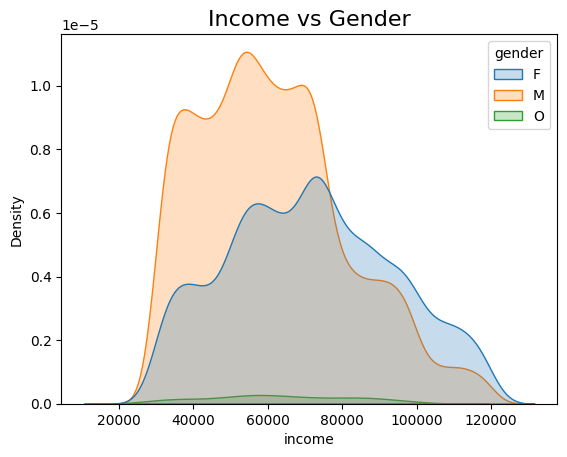

In [35]:
# income vs gender
print(customers.groupby('gender').agg({'income': 'mean'}))
sns.kdeplot(data = customers, x = 'income', hue = 'gender', fill = True)
plt.title('Income vs Gender', fontsize = 16)
plt.show()


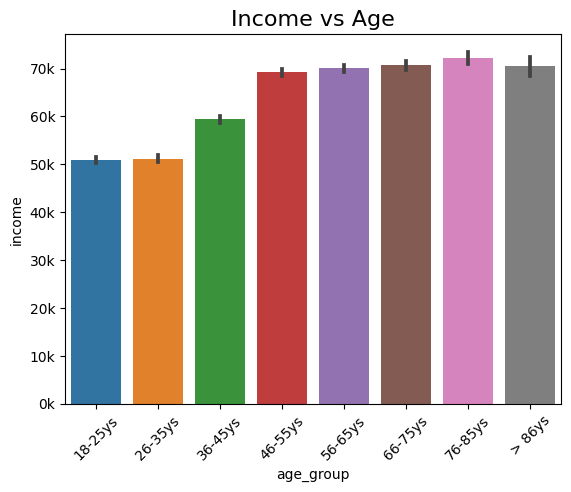

In [36]:
# income vs age
sns.barplot(data = customers, x = 'age_group', y = 'income')
plt.xticks(rotation = 45)
ytick_labels = [str(i) + 'k' for i in (np.arange(0, 80000, 10000) / 1000).astype(int)]
plt.yticks(np.arange(0, 80000, 10000), labels = ytick_labels)
plt.title('Income vs Age', fontsize = 16)
plt.show()

In [37]:
# EDA ON  OFFER DATA


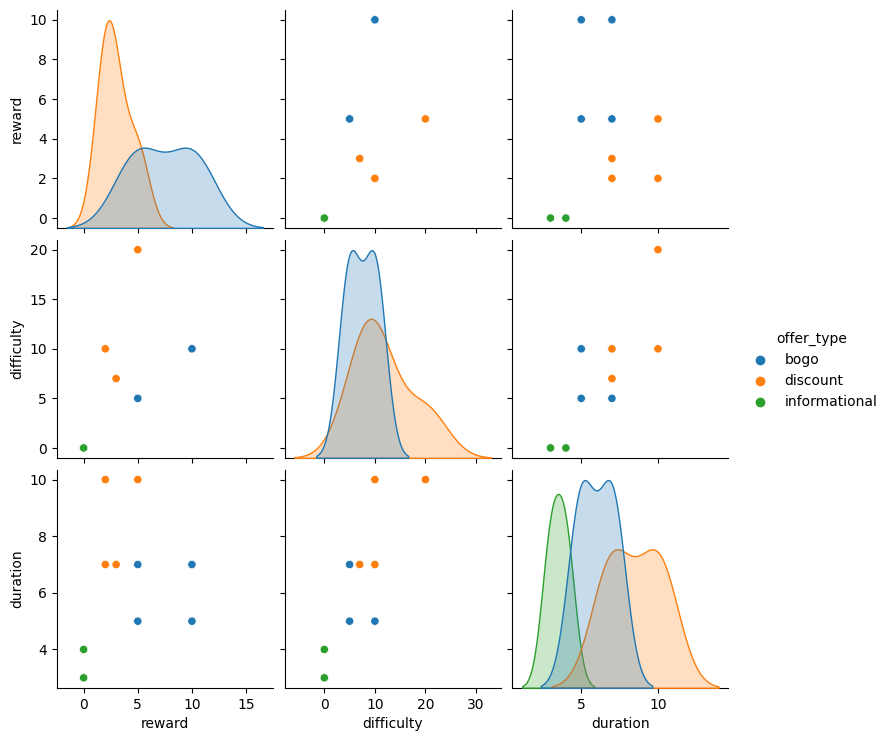

In [38]:
sns.pairplot(offers, hue = 'offer_type')
plt.show()

In [39]:
#  EDA on transcripts data
transcripts['event'].value_counts()


event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

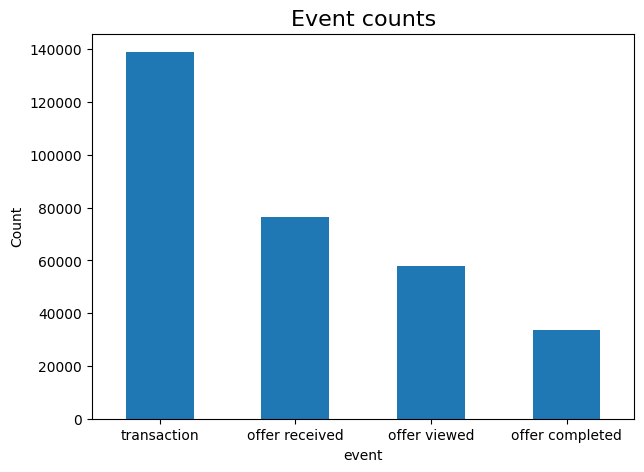

In [40]:
fig = plt.figure(figsize = (7,5))
transcripts['event'].value_counts().plot(kind = 'bar')
plt.xticks(rotation = None)
plt.ylabel('Count')
plt.title('Event counts', fontsize = 16)
plt.show()

In [42]:
# Customer Segmentation


In [43]:
customer_behavior = pd.DataFrame(columns = ['person', 'num_received', 'num_viewed', 'num_completed', 'num_transactions', 'money_spent'])

In [44]:
# Remove rows of customers with missing gender and income
id_to_remove = missing_income['id']
transcripts_filtered = transcripts[~transcripts['person'].isin(id_to_remove)].reset_index(drop = True)

# Add data to `person`, ordered in ascending order
customer_behavior['person'] = transcripts_filtered.value_counts('person').sort_index().index.values

In [45]:
# Aggregate df transcripts
transcripts_filtered = transcripts_filtered.sort_values('person')
transcripts_grouped = transcripts_filtered.groupby(['person', 'event']).count()
transcripts_grouped.head()

dict_key  dict_value   
person                           event                                   
0009655768c64bdeb2e877511632db8f offer completed         3           3  \
                                 offer received          5           5   
                                 offer viewed            4           4   
                                 transaction             8           8   
0011e0d4e6b944f998e987f904e8c1e5 offer completed         3           3   

                                                  hours_since_start  
person                           event                               
0009655768c64bdeb2e877511632db8f offer completed                  3  
                                 offer received                   5  
                                 offer viewed                     4  
                                 transaction                      8  
0011e0d4e6b944f998e987f904e8c1e5 offer completed                  3

In [46]:
customer_behavior.index.values

array([    0,     1,     2, ..., 14822, 14823, 14824], dtype=int64)

In [47]:
customer_behavior

,person,num_received,num_viewed,num_completed,num_transactions,money_spent
0,0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN
1,0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,NaN
2,0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,NaN
3,0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,NaN
4,003d66b6608740288d6cc97a6903f4f0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
14820,fff3ba4757bd42088c044ca26d73817a,NaN,NaN,NaN,NaN,NaN
14821,fff7576017104bcc8677a8d63322b5e1,NaN,NaN,NaN,NaN,NaN
14822,fff8957ea8b240a6b5e634b6ee8eafcf,NaN,NaN,NaN,NaN,NaN
14823,fffad4f4828548d1b5583907f2e9906b,NaN,NaN,NaN,NaN,NaN


In [49]:

for person_id in customer_behavior.index.values:
    if (person_id, 'offer received') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_received'] = transcripts_grouped.loc[(person_id, 'offer received'), 'dict_key']
    if (person_id, 'offer viewed') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_viewed'] = transcripts_grouped.loc[(person_id, 'offer viewed'), 'dict_key']
    if (person_id, 'offer completed') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_completed'] = transcripts_grouped.loc[(person_id, 'offer completed'), 'dict_key']
    if (person_id, 'transaction') in list(transcripts_grouped.index.values):
        customer_behavior.loc[person_id, 'num_transactions'] = transcripts_grouped.loc[(person_id, 'transaction'), 'dict_key']

In [ ]:
# Calculate how much money each customer spent during the month of the campaign
money_spent = transcripts_filtered[transcripts_filtered['event'] == 'transaction'].groupby('person').agg({'dict_value': 'sum'})

# Add to `money_spent`
customer_behavior['money_spent'] = money_spent
customer_behavior.head(3)

,num_received,num_viewed,num_completed,num_transactions,money_spent
person,,,,,
0009655768c64bdeb2e877511632db8f,5,4,3,8,127.6
0011e0d4e6b944f998e987f904e8c1e5,5,5,3,5,79.46
0020c2b971eb4e9188eac86d93036a77,5,3,3,8,196.86


In [ ]:
customer_behavior.isna().sum()

num_received           5
num_viewed           150
num_completed       2839
num_transactions     333
money_spent          333
dtype: int64

In [ ]:
customer_behavior.fillna(0, inplace = True)
customer_behavior.isna().sum()

num_received        0
num_viewed          0
num_completed       0
num_transactions    0
money_spent         0
dtype: int64

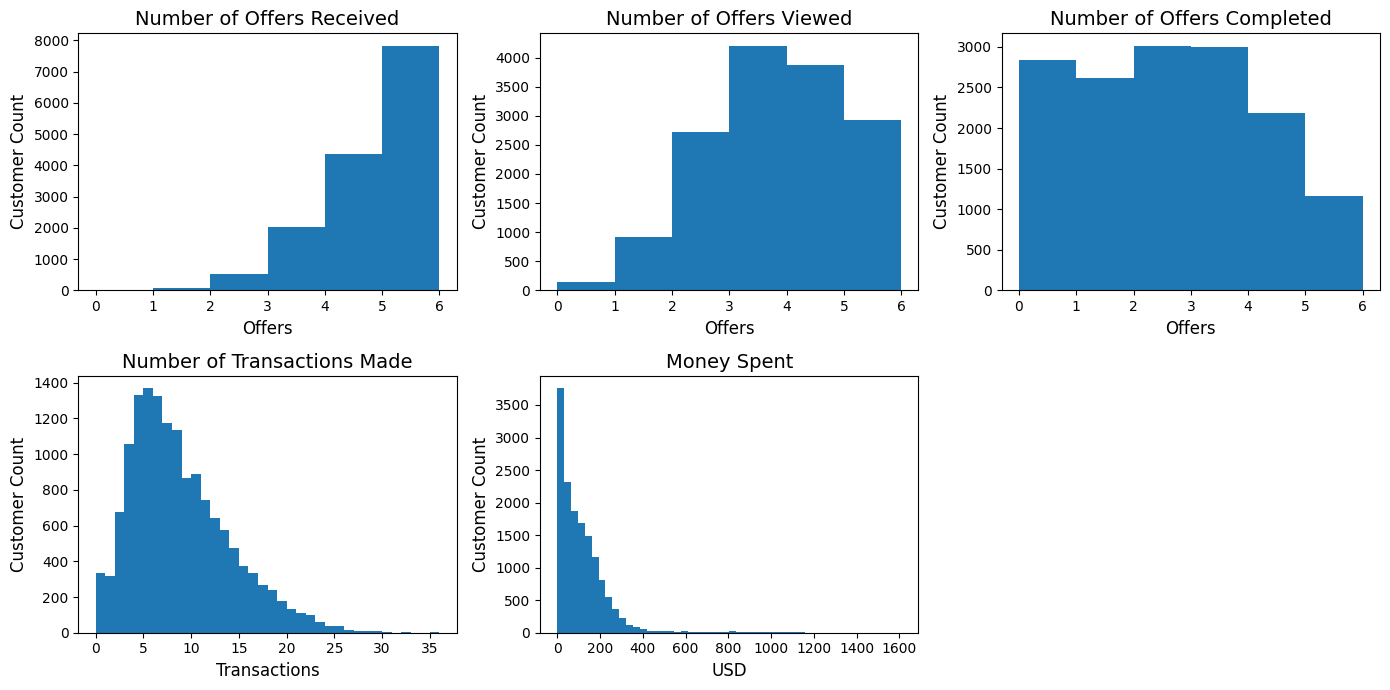

In [ ]:
# Check the features with plots
fig, axs = plt.subplots(2,3, figsize = (14, 7))
fig_titles = ['Number of Offers Received', 'Number of Offers Viewed', 'Number of Offers Completed', 'Number of Transactions Made', 'Money Spent']
x_labels = ['Offers', 'Offers','Offers','Transactions','USD']
y_labels = 'Customer Count'

sub_row, sub_col = 0, 0


for i in range(5):
    if i < 3:
        sub_row = 0
        sub_col = i
        bins = customer_behavior.iloc[:, i].max()
        axs[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins = bins)
        axs[sub_row, sub_col].set_ylabel(y_labels, fontsize = 12)

    else:
        sub_row = 1
        sub_col = i - 3
        if i == 3:
            bins = customer_behavior.iloc[:, i].max()
            axs[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins = bins)
            axs[sub_row, sub_col].set_ylabel(y_labels, fontsize = 12)
        else:
            bins = 50
            axs[sub_row, sub_col].hist(customer_behavior.iloc[:, i], bins = bins)
            axs[sub_row, sub_col].set_ylabel(y_labels, fontsize = 12)
    
    axs[sub_row, sub_col].set_title(fig_titles[i], fontsize = 14)
    axs[sub_row, sub_col].set_xlabel(x_labels[i], fontsize = 12)

axs[1,2].set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
customer_behavior['money_spent'].describe()

count    14825.000000
mean       117.028155
std        129.965016
min          0.000000
25%         31.450000
50%         87.040000
75%        160.900000
max       1608.690000
Name: money_spent, dtype: float64

In [ ]:
q = customer_behavior['money_spent'].quantile(0.98)
rows_top_money_spent = customer_behavior[customer_behavior['money_spent'] >= q]

person_top_money_spent = rows_top_money_spent.index.values
customer_top_money_spent_removed = customer_behavior[customer_behavior['money_spent'] < q]

rows_top_money_spent.shape[0]

297

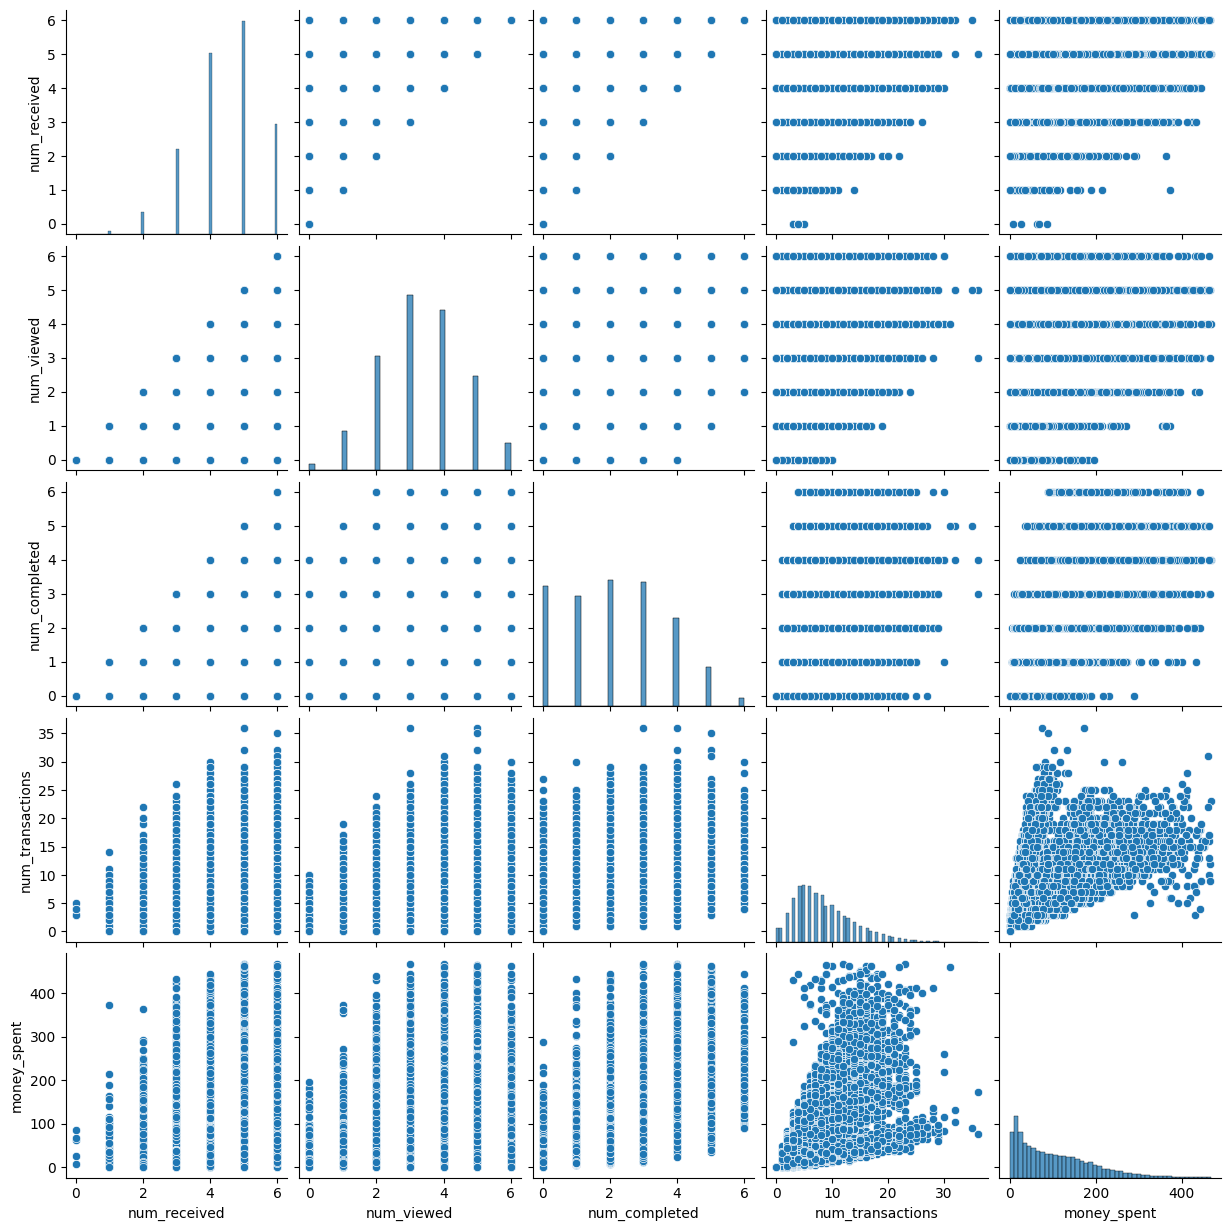

In [ ]:
customer_behavior_filtered = customer_top_money_spent_removed.copy()
sns.pairplot(customer_behavior_filtered); plt.show()

In [ ]:
# K-Means Clustering
scaler_customer_behavior = StandardScaler()
scaler_customer_behavior.fit(customer_behavior_filtered)
customer_behavior_scaled = scaler_customer_behavior.transform(customer_behavior_filtered)
pd.DataFrame(data = customer_behavior_scaled, columns = customer_behavior_filtered.columns.values).head(3)

,num_received,num_viewed,num_completed,num_transactions,money_spent
0,0.482447,0.501233,0.531352,-0.060069,0.277234
1,0.482447,1.276977,0.531352,-0.639666,-0.281415
2,0.482447,-0.274511,0.531352,-0.060069,1.080974


c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

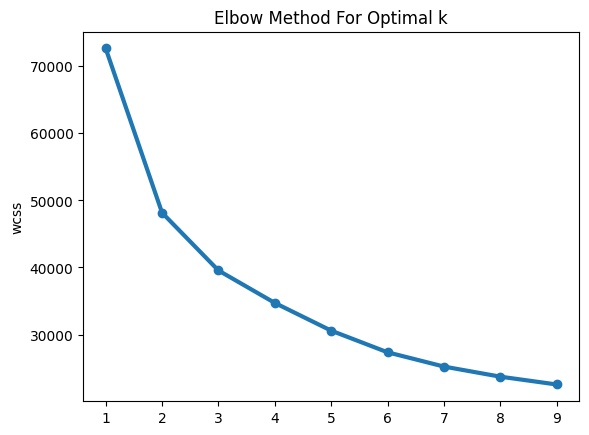

In [ ]:
df_feature = customer_behavior_scaled
df_feature
wcss = []
sil_score = []
max_clusters = 10

for k in range(1, max_clusters):
    kmeans = KMeans(n_clusters = k, random_state = 10)
    kmeans.fit(df_feature)
    wcss.append(kmeans.inertia_)
                 
plt.plot(np.arange(1, max_clusters), wcss, marker = 'o', lw = 3)
plt.ylabel('wcss') 
plt.title('Elbow Method For Optimal k')
plt.show()

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster
0    1497
1    3349
2    3141
3    2978
4    3563
Name: count, dtype: int64

 ************************************************************
Silhouette Score: 0.23769487046847784

 ************************************************************
        num_received num_viewed num_completed num_transactions money_spent
                mean       mean          mean             mean        mean
cluster                                                                   
0                4.8        3.6           2.1             17.3        71.2
1                5.1        4.1           1.2              4.6        43.1
2                4.0        2.9           2.9              8.4       153.9
3                5.3        4.5           4.2             11.6       208.5
4                3.5        2.0           0.8              5.2        42.4


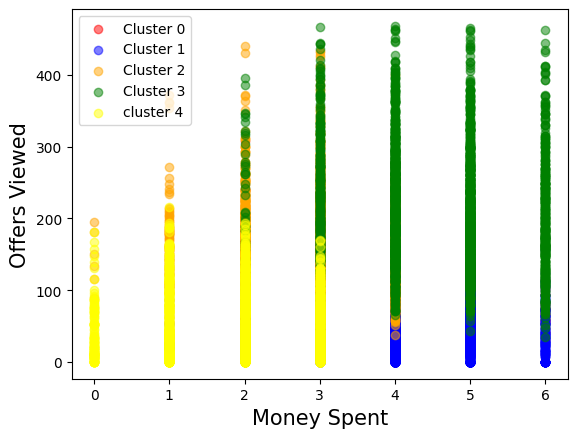

In [ ]:
# K-Means Clustering
k = 5
df_feature = customer_behavior_scaled
kmeans = KMeans(n_clusters = k, random_state = 10)
kmeans.fit_transform(df_feature)
customer_with_cluster = customer_behavior_filtered.assign(cluster = kmeans.labels_)
print(customer_with_cluster.value_counts('cluster').sort_index())

line_sep = '*' * 60
print('\n', line_sep)
print('Silhouette Score:', metrics.silhouette_score(df_feature, labels = kmeans.labels_))

#
cluster_info = customer_with_cluster.groupby('cluster').agg([np.mean])
print('\n', line_sep)
print(cluster_info.round(1))

# Plot
color_list = ['red', 'blue', 'orange', 'green', 'yellow']
legend_list = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'cluster 4']
for i in range(k):
    plt.scatter(customer_with_cluster.loc[customer_with_cluster['cluster'] == i , 'num_viewed'],
               customer_with_cluster.loc[customer_with_cluster['cluster'] == i , 'money_spent'],
               c = color_list[i], label = legend_list[i], alpha = 0.5)
plt.ylabel('Offers Viewed', fontsize = 15)
plt.xlabel('Money Spent', fontsize = 15)
plt.legend(legend_list)
plt.show()

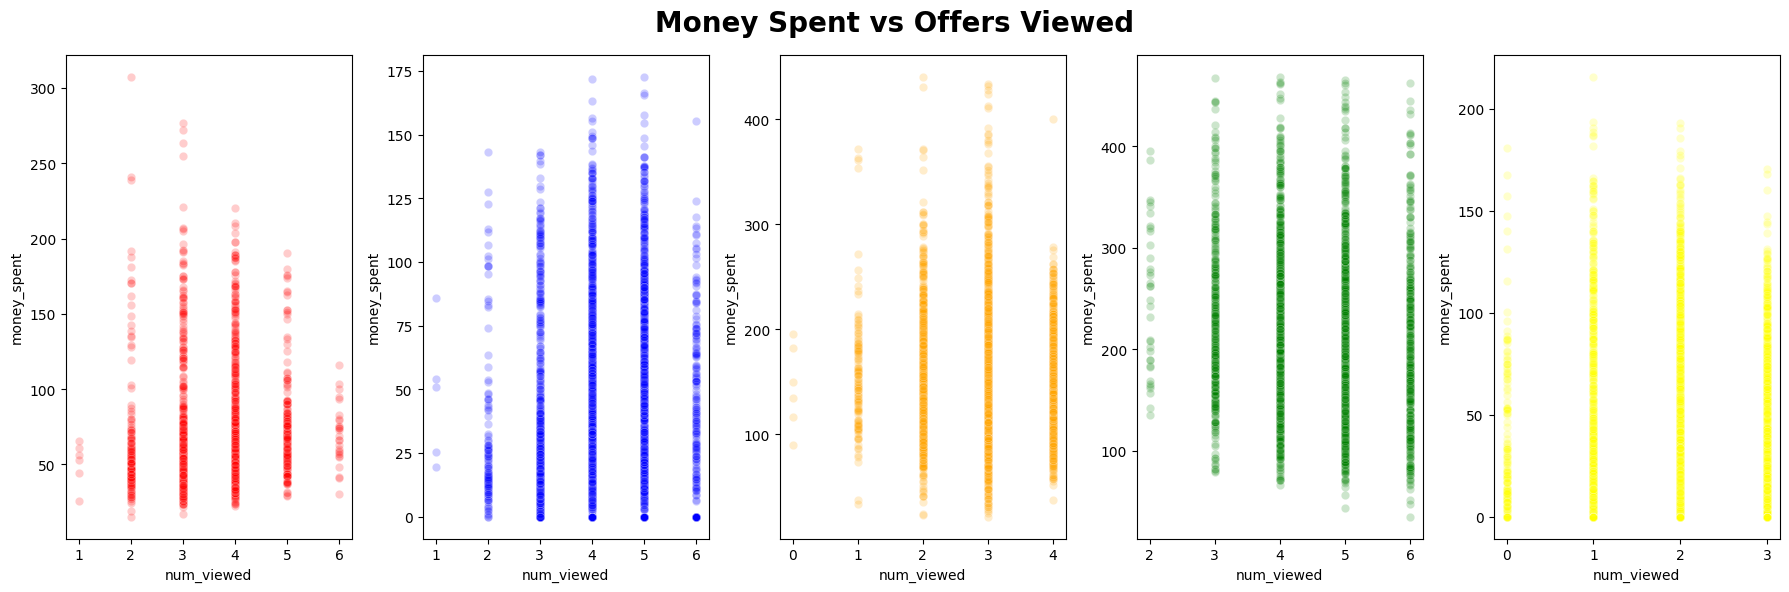

In [ ]:
fig, axs = plt.subplots(1, k, figsize = (18,6))
for i in range(k):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y ='money_spent', alpha = 0.2, color = color_list[i], ax = axs[i])
fig.suptitle('Money Spent vs Offers Viewed', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()    

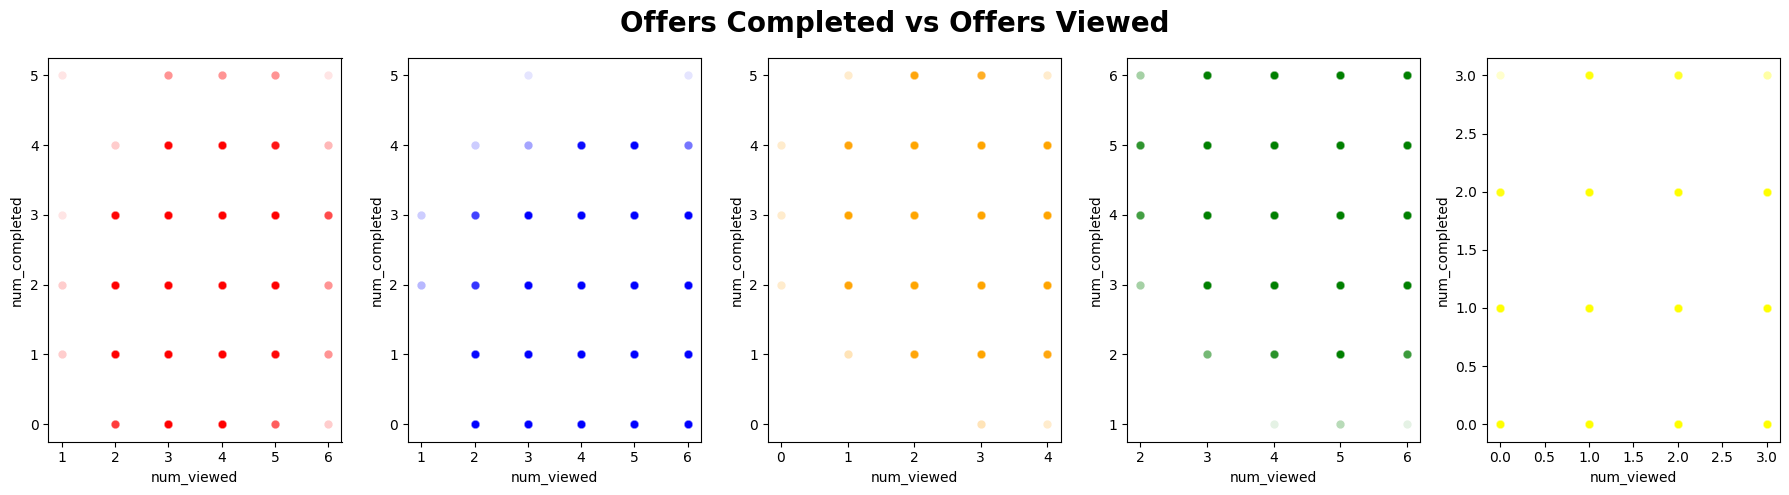

In [ ]:
fig, axs = plt.subplots(1, k, figsize = (18,5))
for i in range(k):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y = 'num_completed', alpha = 0.1, color = color_list[i], ax = axs[i])
fig.suptitle('Offers Completed vs Offers Viewed', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()    

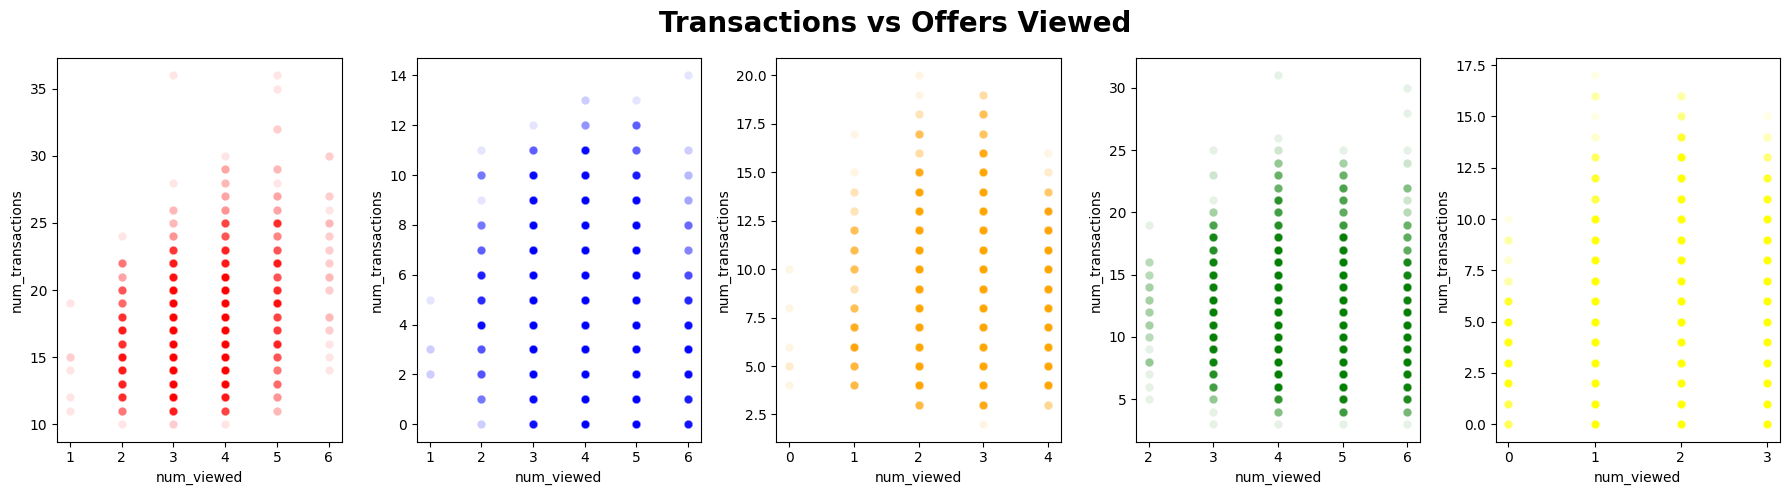

In [ ]:
fig, axs = plt.subplots(1, k, figsize = (18,5))
for i in range(k):
    sns.scatterplot(data = customer_with_cluster[customer_with_cluster['cluster'] == i],
                   x = 'num_viewed', y = 'num_transactions', alpha = 0.1, color = color_list[i], ax = axs[i])
fig.suptitle('Transactions vs Offers Viewed', fontsize = 20, fontweight = 'bold')
plt.tight_layout()
plt.show()    